In [1]:
import os, sys, warnings

current_path = os.path.abspath('.')
parent_path = os.path.dirname(current_path)

sys.path.append(parent_path)
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'child.settings')

from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [3]:
import dalex as dx
titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

preprocess = make_column_transformer(
    (StandardScaler(), ['age', 'fare', 'parch', 'sibsp']),
    (OneHotEncoder(), ['gender', 'class', 'embarked']))

from sklearn.ensemble import RandomForestClassifier

titanic_rf = make_pipeline(
    preprocess,
    RandomForestClassifier(max_depth = 3, n_estimators = 500, random_state=1313))
titanic_rf.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare', 'parch',
                                                   'sibsp']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender', 'class',
                                                   'embarked'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3, n_estimators=500,
                                        random_state=1313))])

In [4]:
johnny_d = pd.DataFrame({'gender': ['male'],
                       'age'     : [8],
                       'class'   : ['1st'],
                       'embarked': ['Southampton'],
                       'fare'    : [72],
                       'sibsp'   : [0],
                       'parch'   : [0]},
                      index = ['JohnnyD'])

In [5]:
titanic_rf.predict_proba(johnny_d)

array([[0.63780576, 0.36219424]])

In [6]:
titanic_rf_exp = dx.Explainer(titanic_rf, 
                    X, y, label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 2207 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x00000217515B8430> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.169, mean = 0.322, max = 0.889
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.828, mean = 0.000605, max = 0.829
  -> model_info        : package sklearn

A new explainer has been created!


In [7]:
bd_johnny = titanic_rf_exp.predict_parts(johnny_d, 
             type = 'break_down')
bd_johnny.result

,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,1,intercept,0.321552,0.321552,1.0,8,Titanic RF Pipeline
1,class,1st,class = 1st,0.386738,0.065186,1.0,7,Titanic RF Pipeline
2,age,8.0,age = 8.0,0.423045,0.036307,1.0,6,Titanic RF Pipeline
3,fare,72.0,fare = 72.0,0.465955,0.042910,1.0,5,Titanic RF Pipeline
4,sibsp,0.0,sibsp = 0.0,0.466760,0.000805,1.0,4,Titanic RF Pipeline
5,parch,0.0,parch = 0.0,0.464256,-0.002503,-1.0,3,Titanic RF Pipeline
6,embarked,Southampton,embarked = Southampton,0.459915,-0.004341,-1.0,2,Titanic RF Pipeline
7,gender,male,gender = male,0.362194,-0.097721,-1.0,1,Titanic RF Pipeline
8,,,prediction,0.362194,0.362194,1.0,0,Titanic RF Pipeline


In [3]:
from local_exploration.ceteris_paribus import CeterisParibus
from local_exploration.break_down import BreakDown

In [9]:
bd = BreakDown(titanic_rf, X, johnny_d)

In [11]:
r = bd.get_results()

In [33]:
r['var_label'] = r['variable_name'].astype(str) + '=' + r['variable_value'].astype(str)

In [34]:
r

,variable_name,variable_value,cumulative,contribution,var_label
0,intercept,0.321552,0.321552,NaN,intercept=0.3215517567333114
1,gender,male,0.230517,-0.091035,gender=male
2,class,1st,0.285288,0.054771,class=1st
3,age,8,0.331486,0.046198,age=8
4,fare,72,0.369890,0.038405,fare=72
5,embarked,Southampton,0.366284,-0.003607,embarked=Southampton
6,parch,0,0.362717,-0.003566,parch=0
7,sibsp,0,0.362194,-0.000523,sibsp=0
8,prediction,0.362194,0.362194,0.000000,prediction=0.36219424275449397


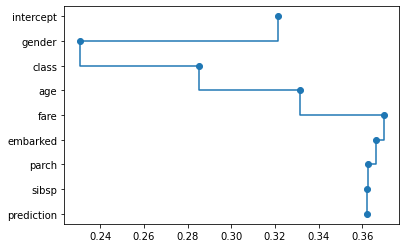

In [39]:
fig, ax = plt.subplots()
ax.step(r.cumulative[::-1], r.variable_name[::-1], where='post')
ax.scatter(r.cumulative[::-1], r.variable_name[::-1])
plt.show()

In [13]:
bd.mean_prediction

0.3215517567333114

In [14]:
bd.model.predict_proba(johnny_d)[:, 1].mean()

0.36219424275449397

In [11]:
bd.get_results()

[0.23051704735582065,
 0.2852880519807029,
 0.33148574584387525,
 0.36989042616434764,
 0.36628374081648,
 0.3627173499117218,
 0.36219424275449397]

In [12]:
bd.model.predict_proba(t)[:, 1].mean()

0.3221078350531227

In [13]:
bd.get_mean_prediction()

0.3221078350531227

In [15]:
bd.get_sorted_scores()

{'gender': 0.09103470937749072,
 'class': 0.0651861773237285,
 'age': 0.042416494480064015,
 'fare': 0.03674465672537297,
 'embarked': 0.004991005915909119,
 'parch': 0.0018162152597848702,
 'sibsp': 0.001618065878573105}

In [3]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

In [4]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [19]:
tmp = pd.DataFrame(X_test.iloc[14]).T

In [20]:
tmp

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
10,68.0,20.0,1.0,1.0,9.0,16.0,40.0,1.0


In [7]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [8]:
from local_exploration.ceteris_paribus import CeterisParibus
from local_exploration.break_down import BreakDown

In [27]:
cp = CeterisParibus(rsf, tmp)

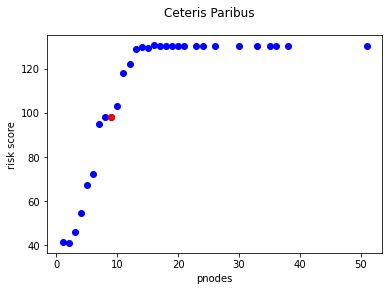

In [29]:
cp.plot(Xt, 'pnodes')

In [23]:
bd = BreakDown(rsf, Xt, tmp)

In [26]:
bd.results

,variable_name,variable_value,cumulative,contribution
0,intercept,78.823317,78.823317,NaN
1,pnodes,9.000000,107.024698,2.820138e+01
2,progrec,16.000000,125.191828,1.816713e+01
3,tsize,40.000000,131.270771,6.078943e+00
4,estrec,20.000000,130.857884,-4.128870e-01
5,horTh=yes,1.000000,124.585521,-6.272363e+00
6,tgrade,1.000000,124.399195,-1.863262e-01
7,menostat=Post,1.000000,123.270733,-1.128462e+00
8,age,68.000000,118.467122,-4.803611e+00
9,prediction,118.467122,118.467122,-1.421085e-14


In [14]:
tmp

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
14,70.0,139.0,1.0,1.0,3.0,113.0,22.0,1.0


In [24]:
print(tmp)

     age  estrec  horTh=yes  menostat=Post  pnodes  progrec  tsize  tgrade
10  68.0    20.0        1.0            1.0     9.0     16.0   40.0     1.0


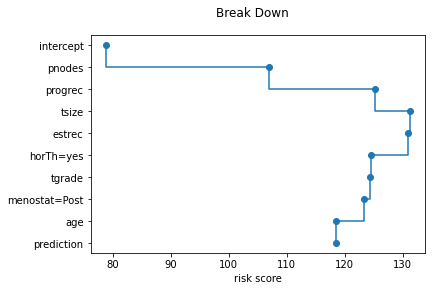

In [25]:
bd.plot()

In [13]:
bd.mean_prediction

78.82331740684067

In [14]:
bd.get_expected_value_for_feature('age')

78.94363980114395

In [15]:
bd.get_score_for_feature('age')

0.12032239430327252

In [16]:
Xt.columns

Index(['age', 'estrec', 'horTh=yes', 'menostat=Post', 'pnodes', 'progrec',
       'tsize', 'tgrade'],
      dtype='object')

In [17]:
s = bd.get_sorted_scores()

In [19]:
bd.get_scores_ordering()

['progrec',
 'pnodes',
 'estrec',
 'horTh=yes',
 'tsize',
 'tgrade',
 'menostat=Post',
 'age']

In [24]:
from sksurv.svm import HingeLossSurvivalSVM, FastKernelSurvivalSVM, FastSurvivalSVM

In [58]:
svm = FastSurvivalSVM(rank_ratio=1, optimizer='direct-count')

In [59]:
svm.fit(X_train, y_train)

FastSurvivalSVM(optimizer='direct-count', rank_ratio=1)

In [45]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [137]:
rsf.estimators_[0].tree_.children_left

array([ 1,  2,  3, -1, -1, -1,  7,  8, -1, -1, 11, 12, -1, 14, 15, -1, -1,
       18, 19, 20, -1, -1, 23, -1, -1, -1, -1], dtype=int64)

In [142]:
tree_tmp = rsf.estimators_[0].tree_

In [157]:
# extract the arrays that define the tree
children_left1 = tree_tmp.children_left
children_right1 = tree_tmp.children_right
children_default1 = children_right1.copy() # because sklearn does not use missing values
features1 = tree_tmp.feature
thresholds1 = tree_tmp.threshold
values1 = tree_tmp.value.reshape(-1, 1)
node_sample_weight1 = tree_tmp.weighted_n_node_samples

print("     children_left1", children_left1) # note that negative children values mean this is a leaf node
print("    children_right1", children_right1)
print("  children_default1", children_default1)
print("          features1", features1)
print("        thresholds1", thresholds1.round(3))
print("            values1", values1.round(3))
print("node_sample_weight1", node_sample_weight1)

     children_left1 [ 1  2  3 -1 -1 -1  7  8 -1 -1 11 12 -1 14 15 -1 -1 18 19 20 -1 -1 23 -1
 -1 -1 -1]
    children_right1 [ 6  5  4 -1 -1 -1 10  9 -1 -1 26 13 -1 17 16 -1 -1 25 22 21 -1 -1 24 -1
 -1 -1 -1]
  children_default1 [ 6  5  4 -1 -1 -1 10  9 -1 -1 26 13 -1 17 16 -1 -1 25 22 21 -1 -1 24 -1
 -1 -1 -1]
          features1 [ 1  0  3 -2 -2 -2  7  0 -2 -2  4  0 -2  3  5 -2 -2  5  1  5 -2 -2  6 -2
 -2 -2 -2]
        thresholds1 [  5.5  57.5   0.5  -2.   -2.   -2.    0.5  50.5  -2.   -2.   12.5  42.5
  -2.    0.5 166.5  -2.   -2.  123.   57.   18.5  -2.   -2.   24.5  -2.
  -2.   -2.   -2. ]
            values1 [[0.   ]
 [1.   ]
 [0.003]
 ...
 [0.095]
 [2.145]
 [0.095]]
node_sample_weight1 [514. 125.  81.  48.  33.  44. 389.  60.  25.  35. 329. 292.  29. 263.
  89.  61.  28. 174. 127.  51.  22.  29.  76.  36.  40.  47.  37.]


In [158]:
rsf.n_estimators

1000

In [181]:
# define a custom tree model
tree_dicts = [
    {
        "children_left": rsf.estimators_[i].tree_.children_left,
        "children_right": rsf.estimators_[i].tree_.children_right,
        "children_default": rsf.estimators_[i].tree_.children_right.copy(),
        "features": rsf.estimators_[i].tree_.feature,
        "thresholds": rsf.estimators_[i].tree_.threshold,
        "values": rsf.estimators_[i].tree_.value,
        "node_sample_weight": rsf.estimators_[i].tree_.weighted_n_node_samples
    } for i in range(rsf.n_estimators)
]
model2 = {
    "trees": tree_dicts,
    # "base_offset": scipy.special.logit(orig_model2.init_.class_prior_[1]),
    # "tree_output": "log_odds",
    # "objective": "binary_crossentropy",
    # "input_dtype": np.float32, # this is what type the model uses the input feature data
    # "internal_dtype": np.float64 # this is what type the model uses for values and thresholds
}

In [182]:
e = shap.TreeExplainer(model2)

ValueError: could not broadcast input array from shape (27,215,2) into shape (27,215)

In [183]:
shaps = e(X_test)

TypeError: only integer scalar arrays can be converted to a scalar index

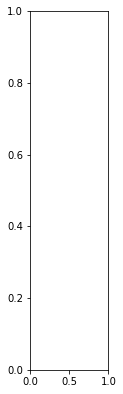

In [179]:
shap.summary_plot(shaps)

In [14]:
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [69]:
coxph.score(X_test, y_test)

0.6654874213836478

In [51]:
rsf.score(X_test, y_test)

NameError: name 'rsf' is not defined

In [52]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


In [8]:
pd.Series(rsf.predict(X_test_sel))

0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64

In [37]:
pd.Series(coxph.predict(X_test_sel))

0    0.821148
1    0.933760
2    0.449849
3    2.350401
4    2.015875
5    2.096120
dtype: float64

In [60]:
pd.Series(svm.predict(X_test_sel))

0    0.336997
1    0.383517
2    0.125609
3    1.137910
4    0.926960
5    1.151259
dtype: float64

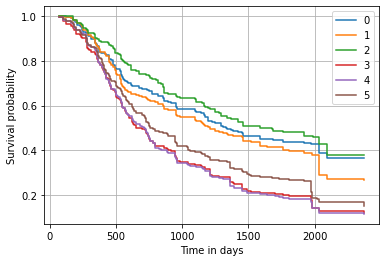

In [9]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

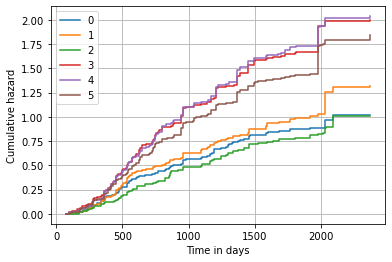

In [10]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [101]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(coxph, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)

PermutationImportance(estimator=CoxPHSurvivalAnalysis(), n_iter=15,
                      random_state=20)

In [102]:
eli5.show_weights(perm, feature_names=Xt.columns.tolist())

Weight,Feature
0.0415 ± 0.0753,progrec
0.0372 ± 0.0199,pnodes
0.0210 ± 0.0210,horTh=yes
0.0126 ± 0.0232,tsize
0.0081 ± 0.0237,tgrade
0.0006 ± 0.0058,estrec
-0.0008 ± 0.0041,menostat=Post
-0.0017 ± 0.0022,age


In [29]:
import shap

In [41]:
exp = shap.Explainer(coxph.predict, Xt, feature_names=Xt.columns)

In [42]:
shap_values2 = exp(Xt)

In [173]:
import dalex as dx

In [183]:
import xgboost

In [184]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [196]:
X

,sex_isFemale,age,physical_activity,serum_albumin,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT,SGOT_isUnacceptable,SGOT_isTestnotdone,...,urine_hematest_isLarge,urine_hematest_isBlankbutapplicable,sedimentation_rate,sedimentation_rate_isBlankbutapplicable,uric_acid,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,pulse_pressure,bmi
20751,False,51,3,NaN,85.0,False,False,NaN,True,False,...,False,False,NaN,False,6.2,False,False,110.0,40.0,25.406803
20753,False,41,2,NaN,68.0,False,False,2.27,False,False,...,False,False,NaN,False,7.7,False,False,136.0,54.0,24.588331
20754,True,31,2,NaN,61.0,False,False,1.86,False,False,...,False,False,NaN,False,4.9,False,False,110.0,24.0,23.756502
20755,False,48,2,NaN,58.0,False,False,NaN,True,False,...,False,False,NaN,False,8.4,False,False,126.0,36.0,28.610011
20756,True,29,3,NaN,37.0,False,False,1.69,False,False,...,False,False,NaN,False,4.3,False,False,98.0,36.0,19.216489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25043,True,63,2,NaN,86.0,False,False,2.24,False,False,...,False,False,NaN,False,7.2,False,False,150.0,65.0,35.425033
25046,True,56,2,NaN,65.0,False,False,2.31,False,False,...,False,False,NaN,False,5.1,False,False,98.0,38.0,22.069132
25049,True,47,2,NaN,46.0,False,False,1.93,False,False,...,False,False,NaN,False,3.2,False,False,108.0,28.0,17.915199
25057,True,61,8,NaN,75.0,False,False,2.29,False,False,...,False,False,NaN,False,6.8,False,False,180.0,68.0,27.331622


In [193]:
(pd.Series(y) > 0).mean()

0.3302720134604599

In [178]:
exp = dx.Explainer(coxph, X_test, y_test['time'])

Preparation of a new explainer is initiated

  -> data              : 172 rows 8 cols
  -> target variable   : 172 values
  -> model_class       : sksurv.linear_model.coxph.CoxPHSurvivalAnalysis (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000024DEE178C10> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -3.38, mean = 0.438, max = 2.35
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 14.3, mean = 1.17e+03, max = 2.56e+03
  -> model_info        : package sksurv

A new explainer has been created!


X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names


In [181]:
exp.model_parts()

,variable,dropout_loss,label
0,_baseline_,1334.849837,CoxPHSurvivalAnalysis
1,pnodes,1334.901733,CoxPHSurvivalAnalysis
2,progrec,1334.903300,CoxPHSurvivalAnalysis
3,tgrade,1334.917761,CoxPHSurvivalAnalysis
4,horTh=yes,1334.921589,CoxPHSurvivalAnalysis
5,tsize,1334.926344,CoxPHSurvivalAnalysis
6,_full_model_,1334.934616,CoxPHSurvivalAnalysis
7,estrec,1334.934653,CoxPHSurvivalAnalysis
8,menostat=Post,1334.935361,CoxPHSurvivalAnalysis
9,age,1334.935389,CoxPHSurvivalAnalysis


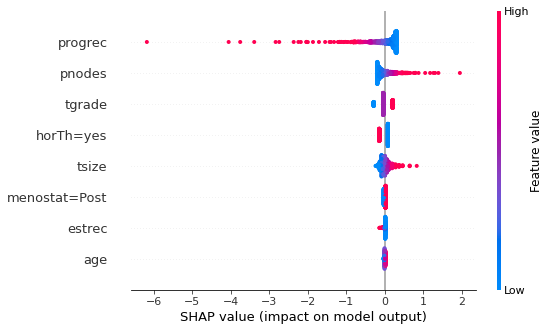

In [43]:
shap.summary_plot(shap_values2)

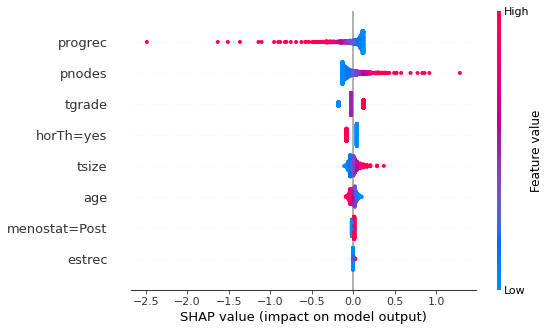

In [40]:
shap.summary_plot(shap_values2)

In [85]:
explainer = shap.Explainer(coxph.predict, Xt, feature_names=Xt.columns)

In [86]:
shap_values = explainer(Xt)

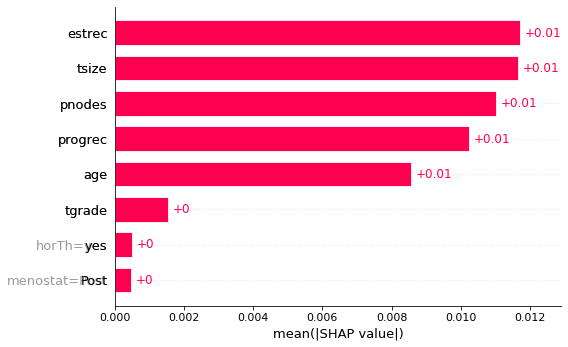

In [14]:
shap.plots.bar(shap_values2)

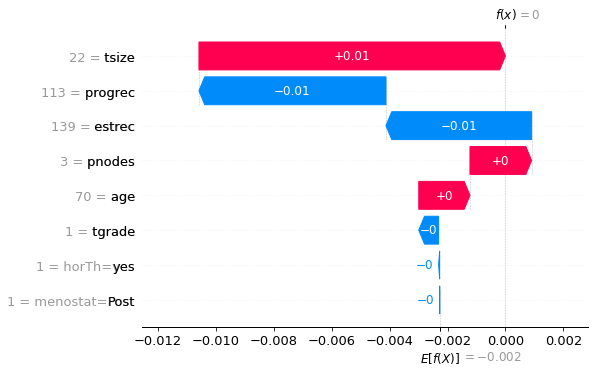

In [15]:
shap.plots.waterfall(shap_values2[0])

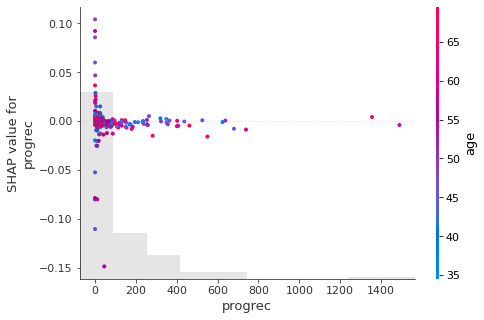

In [16]:
shap.plots.scatter(shap_values2[:, 'progrec'], color=shap_values2)

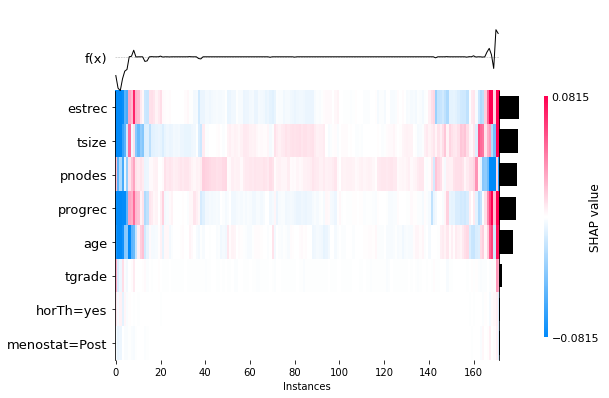

In [17]:
shap.plots.heatmap(shap_values2)

In [19]:
shap.plots.initjs()

In [20]:
shap.plots.force(shap_values2)

In [76]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
rossi = load_rossi()
cph = CoxPHFitter()
cph.fit(df, 'time', 'cens')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1737.17
         time fit was run = 2022-08-02 15:22:27 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age            -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
estrec          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
horTh=yes      -0.34       0.71       0.13            -0.59            -0.08                 0.55                 0.92
menostat=Post   0.27       1.31       0.18            -0.09             0.63                 0.91                 1.87
pnodes          0.05       1.05       0.01             0.04             0.06                 1.04                 1.07
progrec        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
tsize           0.01       1.01       0.00            -0.00             0.02                 1.00                 1.02
tgrade          0.28       1.32       0.11             0.07             0.49                 1.08                 1.63

                cmp to     z      p   -log2(p)
covariate                                     
age               0.00 -1.01   0.31       1.68
estrec            0.00  0.37   0.71       0.50
horTh=yes         0.00 -2.61   0.01       6.81
menostat=Post     0.00  1.46   0.14       2.79
pnodes            0.00  6.73 <0.005      35.82
progrec           0.00 -3.89 <0.005      13.26
tsize             0.00  1.95   0.05       4.30
tgrade            0.00  2.64   0.01       6.93
---
Concordance = 0.69
Partial AIC = 3490.35
log-likelihood ratio test = 101.86 on 8 df
-log2(p) of ll-ratio test = 58.96

In [90]:
coxph.score(Xt, y)

0.6828784417458218

In [120]:
tmp = pd.DataFrame(shap_values.values)

In [121]:
tmp.columns = shap_values.feature_names

In [136]:
tmp.describe()

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
count,6.860000e+02,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,5.954794e-05,-0.001229,0.000313,0.000768,-0.024001,0.002461,-0.000096,-0.013125
std,1.148420e-02,0.020594,0.107427,0.022002,0.234763,0.550681,0.130644,0.143297
min,-3.631101e-02,-0.142180,-0.143254,-0.024924,-0.195940,-6.175761,-0.240705,-0.287672
25%,-7.943033e-03,-0.003616,-0.143254,-0.024924,-0.195940,-0.056747,-0.085352,-0.041798
50%,-9.367507e-17,0.006877,0.080580,0.019583,-0.110189,0.213380,-0.039661,-0.041798
75%,9.077752e-03,0.010644,0.080580,0.019583,0.061312,0.282782,0.051723,-0.041798
max,3.063741e-02,0.011720,0.080580,0.019583,1.947822,0.301834,0.828486,0.204075


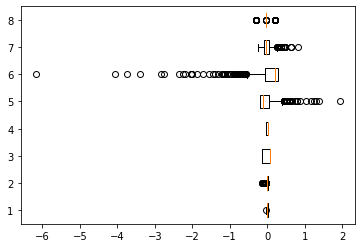

In [139]:
fig, ax = plt.subplots()
ax.boxplot(tmp, vert=False)
plt.show()

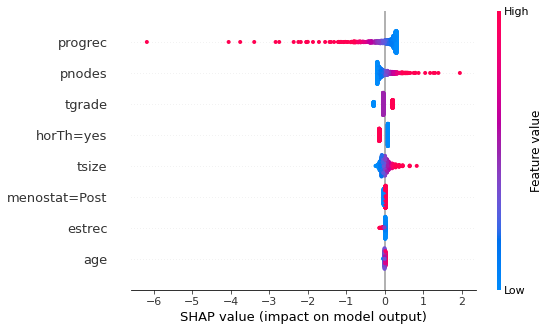

In [155]:
shap.summary_plot(shap_values, show=False)
f = plt.gcf()

In [171]:
f.axes[0]

<AxesSubplot:xlabel='SHAP value (impact on model output)'>

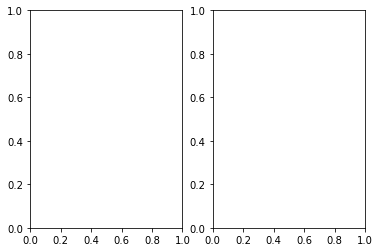

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = f.axes[0]
plt.show()

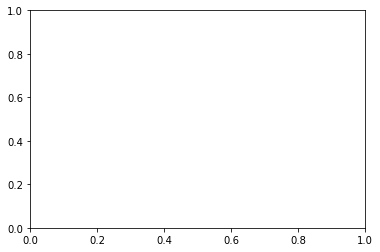

In [108]:
fig, ax = plt.subplots()
ax = plt.gcf()
plt.show()

In [106]:
f

<Figure size 432x288 with 0 Axes>

In [84]:
coxph.coef_.round(2)

array([ 0.  , -0.  , -0.22,  0.04,  0.04, -0.  ,  0.01,  0.25])

In [73]:
df = Xt.copy()

In [74]:
df['cens'] = y['cens'] * 1
df['time'] = y['time']

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            686 non-null    float64
 1   estrec         686 non-null    float64
 2   horTh=yes      686 non-null    float64
 3   menostat=Post  686 non-null    float64
 4   pnodes         686 non-null    float64
 5   progrec        686 non-null    float64
 6   tsize          686 non-null    float64
 7   tgrade         686 non-null    float64
 8   cens           686 non-null    int32  
 9   time           686 non-null    float64
dtypes: float64(9), int32(1)
memory usage: 51.0 KB
